In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsampler import ImbalancedDatasetSampler
import matplotlib.pyplot as plt
import os
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from functools import reduce
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import pandas as pd
import sklearn 

In [2]:
import loaders as l
import models as m
import train_eval as te

In [3]:
train_dir = "C:/Users/33783/Desktop/start_deep/start_deep/Projet_ML/train_images"
test_dir = "C:/Users/33783/Desktop/start_deep/start_deep/Projet_ML/test_images"

transform = transforms.Compose(
    [transforms.Grayscale(), 
     transforms.ToTensor(), 
     transforms.Normalize(mean=(0,),std=(1,))])

valid_size = 0.2
batch_size = 32

train_loader,valid_loader,test_loader=l.make_all_loaders(train_dir,test_dir,transform,valid_size,batch_size)
classes = ('noface','face')

print(train_loader.dataset.targets.count(0))
print(train_loader.dataset.targets.count(1))


26950
64770


BaseNet_v4(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(20, 18, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(18, 16, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)
cuda:0
Started Training
[ 1, 2000] loss: 0.124 f1_score on validation set : 0.982
[ 2, 2000] loss: 0.033 f1_score on validation set : 0.992
[ 3, 2000] loss: 0.020 f1_score on validation set : 0.995
[ 4, 2000] loss: 0.015 f1_score on validation set : 0.996
[ 5, 2000] loss: 0.012 f1_score on validation set : 0.997
[ 6, 2000] loss: 0.012 f1_score on validation set : 0.994
[ 7, 2000] loss: 0.008 f1_scor

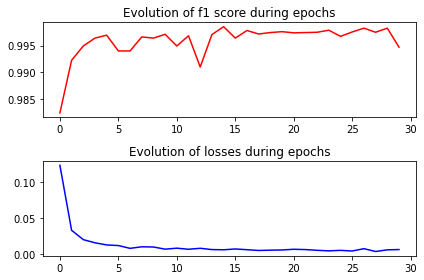

In [4]:
net = m.BaseNet_v4()
print(net)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
#optim.Adam(net.parameters(), lr=0.001)
#optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epochs=30

#Training
print("Started Training")
all_losses,all_accuracies,all_f1scores,all_roc_aucc,best_params= te.train_v1(net,criterion,optimizer,epochs,train_loader,valid_loader,device)
            
#plt.plot(all_losses, color='blue')
#plt.plot(all_f1scores, color='red')
plt.subplot(2, 1, 1)
plt.plot(all_f1scores, color='red')
plt.title('Evolution of f1 score during epochs')
plt.subplot(2, 1, 2)
plt.plot(all_losses, color='blue')
plt.title('Evolution of losses during epochs')
plt.tight_layout()


print("Finished Training")

In [ ]:
#sauvegarder celui avec les meilleures metrics et pas le dernier

In [7]:
saved_model_path='C:/Users/33783/Desktop/start_deep/start_deep/Projet_ML/test_v4'
torch.save(best_params, saved_model_path )

In [9]:
net = m.BaseNet_v4()
net.load_state_dict(torch.load(saved_model_path))
net.to(device)
print(net)
#saved_model_path='C:/Users/33783/Desktop/start_deep/start_deep/Projet_ML/BaseNet_v2_lo0001_30ep'
#torch.save(net.state_dict(), saved_model_path )

BaseNet_v4(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(20, 18, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(18, 16, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


Text(0.5, 1.0, 'ROC curve during epochs')

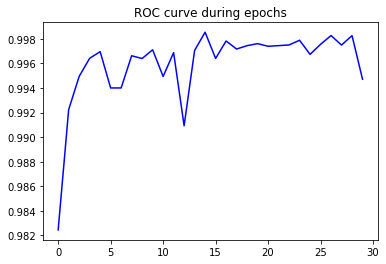

In [5]:

plt.plot(all_roc_aucc, color='blue')
plt.title('ROC curve during epochs')
#f1,_,_,_,roc = te.calc_metrics_v1(net,test_loader,False)
#print(f1)
#print(roc)
#s=roc_auc_score(all_labels, all_predicted)
#print(s)

Validation set
f1_score  0.9491702815776993
precision  0.9546226538799536
recall  0.9542475091767174
confusion matrix
           0         1
0  0.997365  0.002635
1  0.415307  0.584693


<AxesSubplot:>

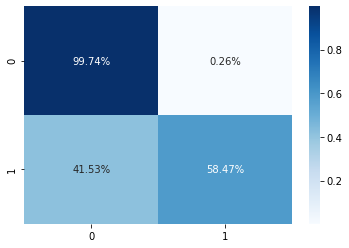

In [12]:
import seaborn as sns
_,_,_,cm,_=te.calc_metrics_v1(net,test_loader,True,device) 
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))